This python notebook is an independent study project for Stats 497 at UCLA focusing on building an SARIMA model. This notebook does the following:
1. Exploratory analysis of the a segment of the Catfish Sales Data located in this repository (see work cited for original data source)
2. Explains and implements the auto correlation function and the partial auto correlation function, then compares the results of each function
3. Explains and implements an SARIMA model on the data. Parameters were manually tuned and tested trying to minimize MSE, AIC, and BIC.
4. Implements a SARIMA that is retrained every time a new test data observation is observed after it passes the current time of the model to show the difference that the change in data can have on a model and highlights the difficulty of modeling on data that is likely to have structural change in the future.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

In [2]:
# Read in data
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/UCLA/Stats 497: Independent Study/catfish.csv'

Mounted at /content/drive


# Catfish Sales Data

### Reading in and formatting data

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')
df = pd.read_csv(file_path, parse_dates=[0], index_col=0, date_parser=parser)

<ipython-input-3-a1ca47ad20d5>:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(file_path, parse_dates=[0], index_col=0, date_parser=parser)


In [4]:
catfish_sales = df.squeeze('columns')
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))
start_date = datetime(1996,1,1)
end_date = datetime(2002,1,1)
lim_catfish_sales = catfish_sales[start_date: end_date]

### Exploratory Analysis
Below our plot shows
*   Clear annual seasonality with regular peaks and troughs.
*   No clear upward or downward trend, suggesting the series may be stationary around a mean.
*   Sharp peaks and drops (e.g., late 1999, early 2001) suggest potential anomalies.

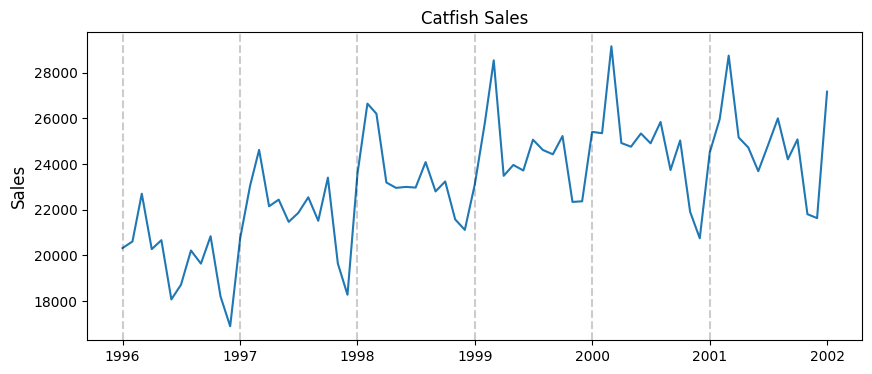

In [5]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales', fontsize=12)
plt.ylabel('Sales', fontsize=12)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Transform using difference
Differencing is applied to data for a SARIMA model for the following reason because there's a clear upward trend. ARIMA requires the time series to be stationary (constant mean, variance, and autocovariance). Differencing removes long-term upward or downward trends and seasonality, which can help the be stationairy. This makes the data suitable for modeling. Applying SARIMA to non-stationary data yield unreliable forecasts and inaccurate parameter estimates.

In [6]:
first_diff = lim_catfish_sales.diff()[1:]

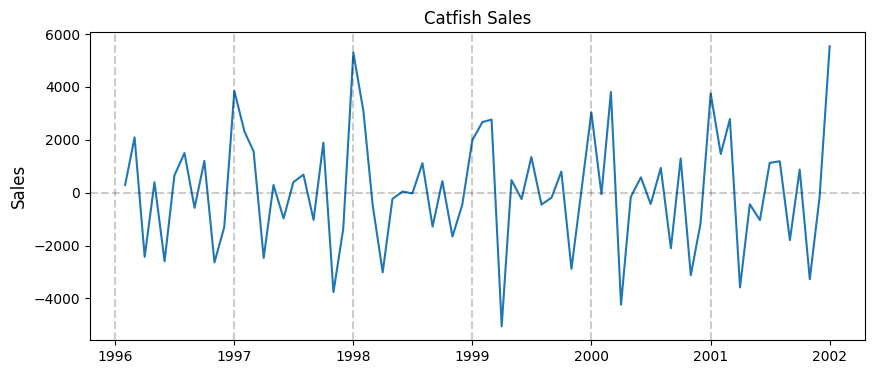

In [7]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales', fontsize=12)
plt.ylabel('Sales', fontsize=12)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# Auto Correlation Function and Partial AutoCorrelation Function

## Autocorrelation Function ACF
### What problem does the ACF solve?
The initial problem is understanding how the current value of a time series is related to it's own past values, depending on time lags. The results help inform the structure of the model such as the order of a MA model or MA component of more involved models.
### How does the ACF work to solve the problem?
$$
\text{ACF}(k) = \frac{\sum_{t=k+1}^N (x_t - \bar{x})(x_{t-k} - \bar{x})}{\sum_{t=1}^N (x_t - \bar{x})^2}
$$

The numerator is the $\text{Cov}(x_t, x_{t+k})$ which measures how parts of observations k lags apart covary.

The denominator $\sum_{t=1}^{N}(x_t - \bar{x})^2$ normalizes the covariance by the total variability in the data, turning it into a correlation. This normalizing step ensures that the ACF values are on a comparable scale [-1, 1]. Thus, even if the time series has large variance, the ACF still measures relative strength of linear dependence on a standardized scale.

By computing $\rho(k)$ for various lags $k = 1, 2, \dots$, K, the ACF reveals how the current value x_t depends on values from the past ($x_{t-1}, x_{t-2}, \dots)$. This helps build linear models because it provides insight into which lags p are most relevant by show where correlation is strongest.

### Manual Implementatation of ACF function

In [8]:
import numpy as np

def acf_manual(series, nlags=40):
    x = np.asarray(series, dtype=float)
    n = len(x)
    mean_x = np.mean(x)
    denom = np.sum((x - mean_x)**2)

    acf_values = []

    for k in range(nlags+1):
        numerator = float(0)
        for t in range(n - k):
            numerator += (x[t] - mean_x) * (x[t + k] - mean_x)
        acf_k = numerator / denom
        acf_values.append(acf_k)

    return np.array(acf_values)

### Compare Manual ACF with Package ACF

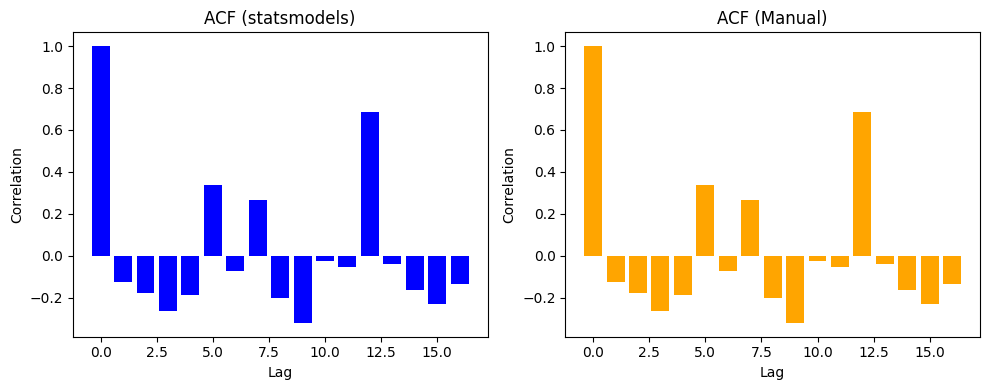

In [9]:
acf_vals = acf(first_diff)
acf_manual_vals = acf_manual(first_diff)
num_lags = 17

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].bar(range(num_lags), acf_vals[:num_lags], color='blue')
axes[0].set_title('ACF (statsmodels)')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Correlation')

axes[1].bar(range(num_lags), acf_manual_vals[:num_lags], color='red')
axes[1].set_title('ACF (Manual)')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Correlation')

plt.tight_layout()
plt.show()

## Partial Autocorrelation Function (PACF)
### What problem does the PACF solve?
The initial problem is understanding how to distinguish direct relationships between a time series and it's own past values from indirect relationships between past shorter lags. The PACF aims to isolate the direct lag effects from the indirect effects of intermediate lags.

### How does the PACF work to solve the problem?
The partial autocorrelation at lag k, \phi_{kk}, can be understood as the correlation between x_t and x_{t-k} after removing the linear effects of all intervening lags.

$$\phi_{11} = \text{Corr}(x_{t+1} ,\, x_{1})$$

$$\phi_{hh} = \text{Corr}(x_{t+h} - \hat{x}_{t+h},\, x_{t} - \hat{x}_{t}) ,\, h \geq 2 $$

By using predictions that account for the shorter lags, we “partial out” their influence, isolating the direct relationship at lag k.

### Manual Implementation of PACF

In [10]:
def pacf_manual(series, nlags=40):
    """
    Levinson-Durbin recursion: pg 112 Time Series Analysis and It's Applications
    with examples in R
    """
    acf_values = acf_manual(series, nlags=nlags)
    phi = np.zeros(nlags+1)
    pacf_values = np.zeros(nlags+1)
    sigma = np.zeros(nlags+1)

    # Start recursion k = 1
    pacf_values[0] = float(1)
    sigma[0] = float(1.0)

    phi[1] = acf_values[1]
    pacf_values[1] = phi[1]
    sigma[1] = sigma[0] * (1 - phi[1]**2)

    # continue recurrsino if k>=2
    for k in range(2, nlags+1):
        numerator = acf_values[k]
        for j in range(1, k):
            numerator -= phi[j] * acf_values[k-j]

        ak = numerator / sigma[k-1]

        phi_old = phi.copy()
        for j in range(1, k):
            phi[j] = phi_old[j] - ak * phi_old[k-j]

        phi[k] = ak
        pacf_values[k] = phi[k]

        sigma[k] = sigma[k-1] * (1 - ak**2)

    return pacf_values


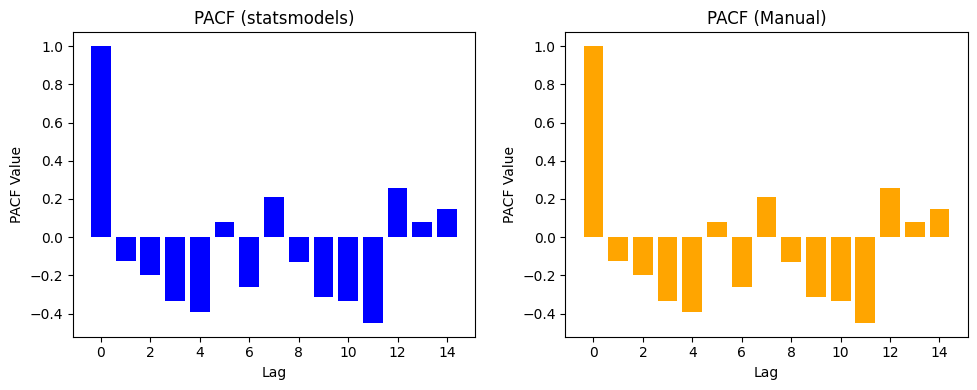

In [11]:
pacf_vals = pacf(first_diff, method='ldb')
pacf_manual_vals = pacf_manual(first_diff)
num_lags = 15


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].bar(range(num_lags), pacf_vals[:num_lags], color='blue')
axes[0].set_title('PACF (statsmodels)')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('PACF Value')

axes[1].bar(range(num_lags), pacf_manual_vals[:num_lags], color='red')
axes[1].set_title('PACF (Manual)')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('PACF Value')

plt.tight_layout()
plt.show()

# SARIMA Models
The ARIMA model combines autoregressive (AR), differencing (I), and moving average (MA) components to model non-seasonal time series. SARIMA models time series with seasonal patterns, which ARIMA cannot handle effectively. It adds seasonal components to capture periodic fluctuations.

$$
\phi(B)(1-B)^d x_t = \theta(B) w_t
$$

*   $B$ : Backward shift operator $( Bx_t = x_{t-1} )$.
*   $(1-B)^d$ : Differencing to make $x_t$ stationary.
*   $\phi(B) = 1 - \phi_1 B - \dots - \phi_p B^p$ : AR polynomial.
*   $\theta(B) = 1 + \theta_1 B + \dots + \theta_q B^q$ : MA polynomial.
*   $w_t \sim N(0, \sigma^2)$ : White noise.



SARIMA extends ARIMA by including seasonal differencing and seasonal AR/MA terms.


$$\phi(B)\Phi(B^s)(1-B)^d (1-B^s)^D x_t = \theta(B)\Theta(B^s) w_t$$


Where:
*   $(1-B^s)^D$ : adds seasonal differencing of order D with periods to remove periodic trends..
*   $\phi(B^s) = 1 - \phi_1 B^s - \dots - \phi_P B^{Ps}$ : Seasonal AR polynomial.
*   $\theta(B^s) = 1 + \theta_1 B^s + \dots + \theta_Q B^{Qs}$ : Seasonal MA polynomial.




## Fit the SARIMA Model

In [12]:
train_end = datetime(1999,7,1)
train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1):datetime(2002,1,1)]
my_order = (0,1,1)
my_seasonal_order = (1, 1, 0, 12)
model = SARIMAX(train_data,
                order=my_order,           # Non-seasonal parameters (p, d, q)
                seasonal_order=my_seasonal_order,  # Seasonal parameters (P, D, Q, m)
)
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                -251.213
Date:                             Mon, 16 Dec 2024   AIC                            508.427
Time:                                     20:59:21   BIC                            512.630
Sample:                                 01-01-1996   HQIC                           509.772
                                      - 07-01-1999                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5562      0.124     -4.483      0.000      -0.799      -0.313
ar.S.L12      -0.2886      

## SARIMA Model Comparison

In [13]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

class ManualSARIMA:
    def __init__(self, order, seasonal_order, train_data):

        self.p, self.d, self.q = order
        self.P, self.D, self.Q, self.m = seasonal_order
        self.train_data = pd.Series(train_data, dtype=float)

        self.params = None

    def _difference(self, data):
        diff_data = data.copy()
        # Non-seasonal differencing
        for _ in range(self.d):
            diff_data = diff_data.diff().dropna()
        # Seasonal differencing
        for _ in range(self.D):
            diff_data = diff_data.diff(self.m).dropna()
        return diff_data

    def _neg_log_likelihood(self, params, data_seasonal_diff):
        p, q = self.p, self.q
        P, Q, m = self.P, self.Q, self.m

        ar_params = params[:p]
        ma_params = params[p:p+q]
        seasonal_ar_params = params[p+q:p+q+self.P]
        seasonal_ma_params = params[p+q+self.P:p+q+self.P+self.Q]

        values = data_seasonal_diff.values
        n = len(values)

        residuals = np.zeros(n)
        max_lag = max(p, q, self.P*m, self.Q*m)

        for t in range(max_lag, n):
            ar_term = 0.0
            for i in range(p):
                ar_term += ar_params[i] * values[t-(i+1)]

            ma_term = 0.0
            for i in range(q):
                ma_term += ma_params[i] * residuals[t-(i+1)]

            seasonal_ar_term = 0.0
            for i in range(self.P):
                lag = m*(i+1)
                if t-lag >= 0:
                    seasonal_ar_term += seasonal_ar_params[i] * values[t-lag]

            seasonal_ma_term = 0.0
            for i in range(self.Q):
                lag = m*(i+1)
                if t-lag >= 0:
                    seasonal_ma_term += seasonal_ma_params[i] * residuals[t-lag]

            prediction = ar_term + ma_term + seasonal_ar_term + seasonal_ma_term
            residuals[t] = values[t] - prediction

        sigma2 = np.var(residuals[max_lag:], ddof=1)
        n_eff = n - max_lag
        nll = 0.5 * n_eff * (np.log(2 * np.pi) + np.log(sigma2) + 1)
        return nll

    def fit(self):
        data_seasonal_diff = self._difference(self.train_data)
        total_params = self.p + self.q + self.P + self.Q
        init_params = np.zeros(total_params) + 0.1
        bounds = [(-1, 1)] * total_params

        res = minimize(self._neg_log_likelihood, init_params,
                       args=(data_seasonal_diff,),
                       method='L-BFGS-B', bounds=bounds)
        self.params = res.x
        return self.params

    def _invert_forecast(self, forecast_diff):
        # no differencing:
        if self.d == 0 and self.D == 0:
            last_val = self.train_data.iloc[-1]
            return forecast_diff

        # simple case: d=1, D=0
        if self.d == 1 and self.D == 0:
            last_data_value = self.train_data.iloc[-1]
            forecast_original = []
            current_val = last_data_value
            for diff_val in forecast_diff:
                current_val = current_val + diff_val
                forecast_original.append(current_val)
            return forecast_original

        return forecast_diff

    def forecast(self, steps):
        if self.params is None:
            raise ValueError("Model not fitted. Call fit() first.")

        p, q = self.p, self.q
        P, Q, m = self.P, self.Q, self.m
        ar_params = self.params[:p]
        ma_params = self.params[p:p+q]
        seasonal_ar_params = self.params[p+q:p+q+self.P]
        seasonal_ma_params = self.params[p+q+self.P:p+q+self.P+self.Q]

        data_seasonal_diff = self._difference(self.train_data)
        values = data_seasonal_diff.values.tolist()
        residuals = [0]*len(values)
        forecasts_diff = []

        for i in range(steps):
            t = len(values)
            ar_term = 0.0
            for j in range(p):
                idx = t-(j+1)
                if idx >= 0:
                    ar_term += ar_params[j]*values[idx]

            ma_term = 0.0
            for j in range(q):
                idx = t-(j+1)
                if idx >= 0 and idx < len(residuals):
                    ma_term += ma_params[j]*residuals[idx]

            seasonal_ar_term = 0.0
            for j in range(self.P):
                lag = m*(j+1)
                idx = t-lag
                if idx >= 0:
                    seasonal_ar_term += seasonal_ar_params[j]*values[idx]

            seasonal_ma_term = 0.0
            for j in range(self.Q):
                lag = m*(j+1)
                idx = t-lag
                if idx >= 0 and idx < len(residuals):
                    seasonal_ma_term += seasonal_ma_params[j]*residuals[idx]

            f = ar_term + ma_term + seasonal_ar_term + seasonal_ma_term
            forecasts_diff.append(f)
            values.append(f)
            residuals.append(0)
        forecast_original_scale = self._invert_forecast(forecasts_diff)
        return forecast_original_scale


In [14]:
custom_model = ManualSARIMA(my_order, my_seasonal_order, train_data)
custom_model.fit()

array([-0.9340272 , -0.43884786])

In [15]:
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

predictions_custom = custom_model.forecast(steps=len(test_data))
predictions_custom = pd.Series(predictions_custom, index=test_data.index)
residuals_custom = test_data - predictions_custom

Inversion for D>0 or d>1 not fully implemented. Returning differenced forecasts.


In [16]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f"RMSE: {rmse}")

rmse_custom = np.sqrt(mean_squared_error(test_data, predictions_custom))

RMSE: 1880.7628123719498


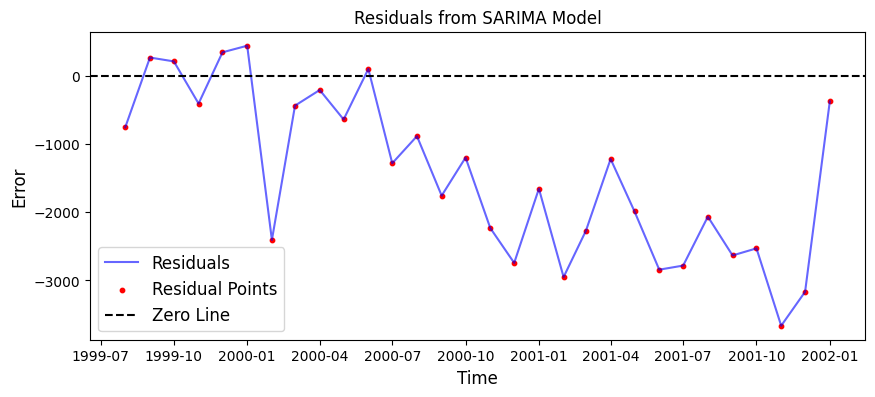

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(residuals.index, residuals, label='Residuals', color='blue', alpha=0.6)
plt.scatter(residuals.index, residuals, color='red', label='Residual Points', s=10)
plt.axhline(0, linestyle='--', color='k', label='Zero Line')
plt.title('Residuals from SARIMA Model', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(fontsize=12)
plt.show()

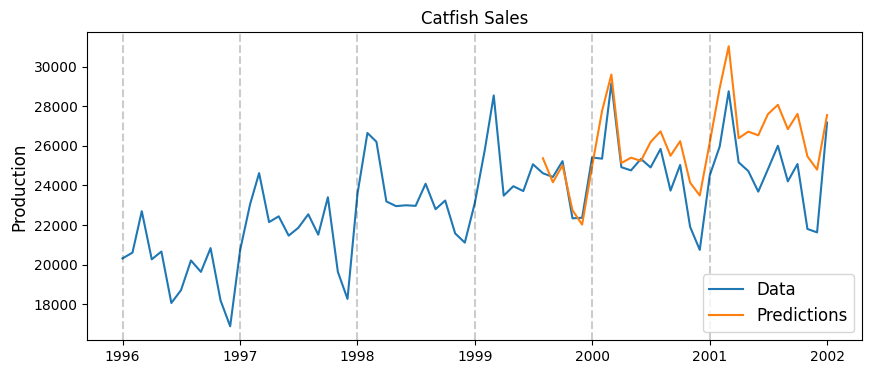

In [18]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Actual Sales', 'Predicted Sales'), fontsize=12)

plt.title('Catfish Sales', fontsize=12)
plt.ylabel('Production', fontsize=12)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# SARIMA Results
The RMSE of this model 1880.7628. The residuals become worse in the latter half ot the test data. The model drifts and deviates from the data since the annual sales trend from 2001 to 2002 seems to begin to decelerate. The model may not fully account for external factors or shocks (like the 2001 to 2002 tech bubble bursting) that cause unexpected spikes or drops. Also, over time, the underlying data distribution may have changed, reducing the accuracy of older model parameters.

## Retrain Model After Test Value is Observed
Retrain the model after the current data point is observed to predict the next set of predictions. It seems like the trend is changing but the seasonality and shape is continuing.

In [19]:
trailing_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()
    trailing_predictions[train_end] = model_fit.forecast()

<ipython-input-19-8b3db94e853a>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25373.45861161]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rolling_predictions[train_end] = model_fit.forecast()
<ipython-input-19-8b3db94e853a>:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = model_fit.forecast()
<ipython-input-19-8b3db94e853a>:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = model_fit.forecast()
<ipython-input-19-8b3db94e853a>:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_e

In [20]:
trailing_residuals = test_data - trailing_predictions

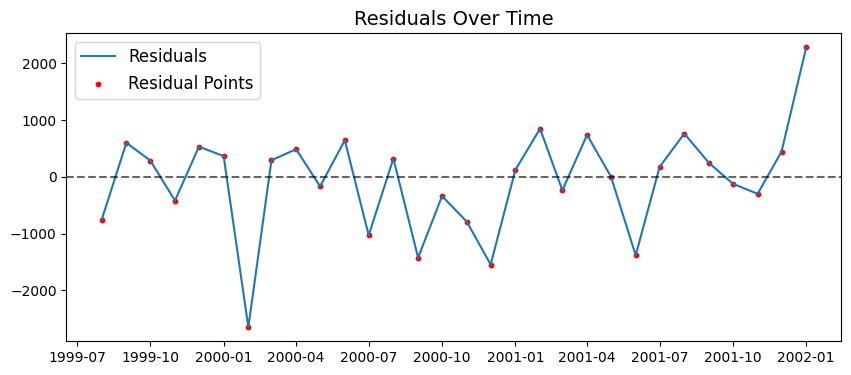

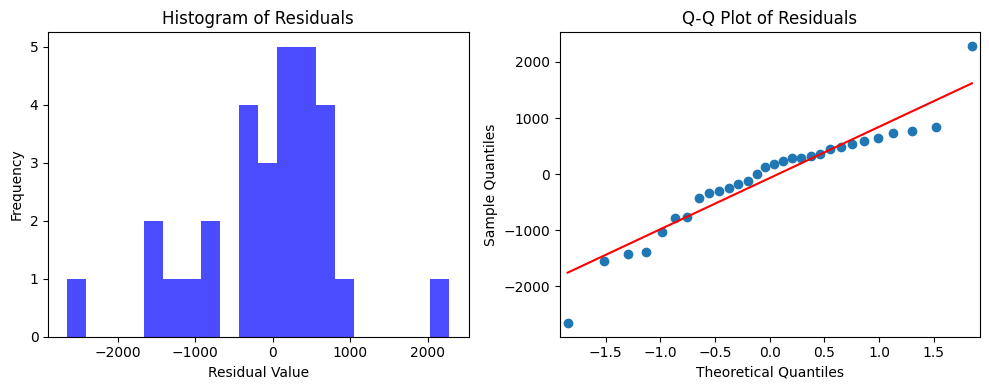

In [35]:
from scipy.stats import shapiro
import statsmodels.api as sm

plt.figure(figsize=(10, 4))
plt.plot(trailing_residuals, label='Residuals')
plt.scatter(trailing_residuals.index, trailing_residuals, color='red', label='Residual Points', s=10)
plt.axhline(0, linestyle='--', color='k', alpha=0.6)
plt.title('Residuals Over Time', fontsize=14)
plt.legend(fontsize=12)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(trailing_residuals, bins=20, color='blue', alpha=0.7)
axes[0].set_title("Histogram of Residuals")
axes[0].set_xlabel("Residual Value")
axes[0].set_ylabel("Frequency")

# qq plot
sm.qqplot(trailing_residuals, line='s', ax=axes[1])
axes[1].set_title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

In [33]:
shapiro_test = shapiro(trailing_residuals)
print(f"Shapiro-Wilk Test for Normality: W = {shapiro_test.statistic}, p-value = {shapiro_test.pvalue}")

Shapiro-Wilk Test for Normality: W = 0.9391123204997815, p-value = 0.08608857334760057


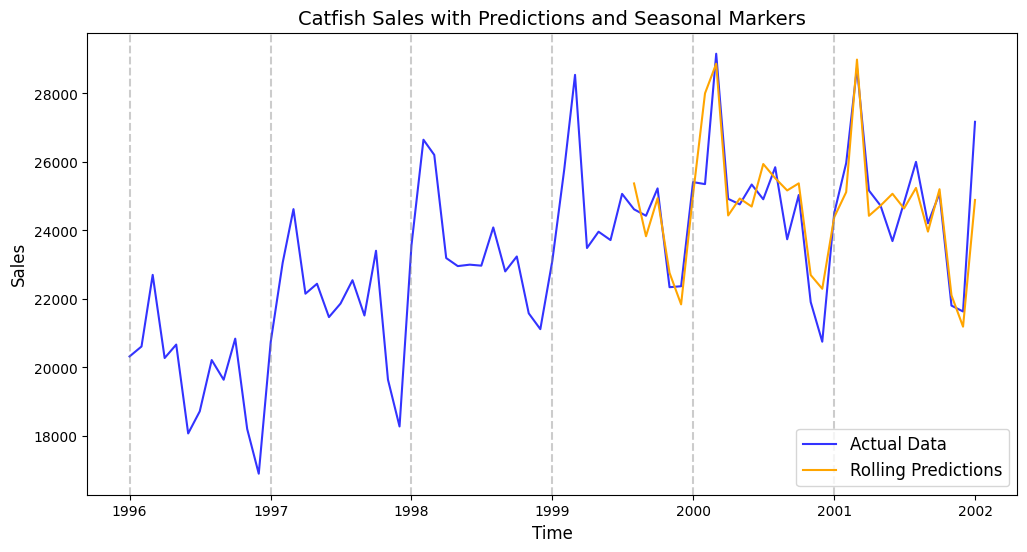

In [28]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(trailing_predictions)

plt.legend(('Data', 'Predictions'), fontsize=12)

plt.title('Catfish Sales', fontsize=12)
plt.ylabel('Production', fontsize=12)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

plt.figure(figsize=(12, 6))

plt.plot(lim_catfish_sales, label='Actual Data', color='blue', alpha=0.8)

plt.plot(trailing_predictions, label='Rolling Predictions', color='red')

for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(f"{year}-01-01"), color='gray', linestyle='--', alpha=0.4)

plt.title('Catfish Sales with Predictions and Seasonal Markers', fontsize=14)
plt.legend(fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.show()

In [23]:
print('RMSE', np.sqrt(np.mean(trailing_residuals**2)))

RMSE 915.2324051168913


# SARIMA results

In the first SARIMA model, the residuals worsen because the sales are drifting. As a result, there is a structural bias that the model is not accounting for.
However, if we retrain the model as soon as the test point is observed, the model performs more closely to the actual data.

The model where can re-train the model as new test events pass in time is 915.23, which is less than the RMSE, 1880.7628, of the model we did not retrain with trailing test events.

Depending on the context of the problem, retraining the model with the most up to date data can be crucial to obtaining a more accurate model.



Cited

* [Time Series Analysis and It's Applications with R](https://link.springer.com/book/10.1007/978-3-319-52452-8)

* [Cat Fish Data](https://github.com/ritvikmath/Time-Series-Analysis/blob/master/catfish.csv)

* [Cat Fish Data](https://github.com/ritvikmath/Time-Series-Analysis/blob/master/SARIMA%20Model.ipynb)
